In [95]:
import pandas as pd
import pickle
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors

### Read data

In [97]:
recs = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)

In [11]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [12]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [13]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [15]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(model, open('SVM_trained.sav', 'wb'))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [19]:
# save the model to disk
pickle.dump(svm, open('SVM_trained.sav', 'wb'))

### Transform recommendations to tf-idf

In [28]:
recs_tfidf = v.transform(recs["full_text"].values)

### Predictions

In [30]:
predictions = svm.predict(sample)

In [69]:
recs["conspiracy_pred"] = predictions

In [70]:
recs[recs["conspiracy_pred"]]

,user,vids_watched,vid,views,likes,dislikes,duration,full_text,conspiracy_pred
7,scriptiebot1@gmail.com,1,sjkrrmBnpGE,14346593.0,117289.0,3040.0,PT3H57M52S,ambient studi music concentr 4 hour music stud...,True
29,scriptiebot1@gmail.com,2,DslTxXsDLsw,173460.0,3819.0,28.0,PT1H9M2S,69 minut manhattan night drone aerial footag m...,True
35,scriptiebot1@gmail.com,2,gVKEM4K8J8A,37550582.0,273609.0,21741.0,PT4H4S,heavi thunderstorm sound relax rain thunder li...,True
45,scriptiebot1@gmail.com,3,jSYto3FAJUA,170389.0,7438.0,54.0,PT5M44S,best 3 remedi psoriasi talk dr berg keto consu...,True
46,scriptiebot1@gmail.com,3,OT2b5KzMoC0,28198849.0,204178.0,4172.0,PT3M12S,toni stark meet natasha romanoff want one iron...,True
...,...,...,...,...,...,...,...,...,...
1396,scriptiebot5@gmail.com,14,N0zZmh-JFyM,5254946.0,64887.0,2747.0,PT16M31S,oprah interview woman 92 person oprah winfrey ...,True
1397,scriptiebot5@gmail.com,14,CyYHlYPEpfQ,1316329.0,41665.0,1099.0,PT10M29S,jesu warn heaven shock must hear jesu warn kev...,True
1400,scriptiebot5@gmail.com,15,G8aZZVBWg1s,613192.0,7139.0,219.0,PT8M30S,disorgan hebephren schizophrenia interview 198...,True
1402,scriptiebot5@gmail.com,15,N0zZmh-JFyM,5254946.0,64887.0,2747.0,PT16M31S,oprah interview woman 92 person oprah winfrey ...,True


## Aggregates

In [76]:
recs_2 = recs[["vids_watched", "views", "likes", "dislikes", "duration", "conspiracy_pred"]].copy()

recs_2.head()

,vids_watched,views,likes,dislikes,duration,conspiracy_pred
0,1,6708535.0,124784.0,5625.0,PT5M3S,False
1,1,22824307.0,236476.0,4479.0,P0D,False
2,1,83168.0,1456.0,12.0,PT48M20S,False
3,1,8784881.0,103138.0,3495.0,P0D,False
4,1,408031.0,10729.0,380.0,PT58M1S,False


In [77]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [78]:
recs_2["duration"] = recs_2["duration"].apply(lambda x: to_seconds(str(x)))

In [89]:
agg = recs_2.groupby("vids_watched")

<AxesSubplot:xlabel='vids_watched'>

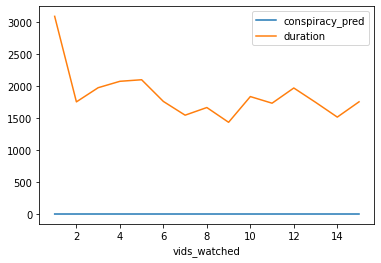

In [94]:
agg[["conspiracy_pred", "duration"]].mean().plot()

## Possible new strategy

In [139]:
# This is the video we're watching
test = recs.iloc[95]

In [140]:
# These are its recommendations
spoof = recs.iloc[100:120]

In [141]:
# Now, find to which recommendations the current video is closest
v2 = TfidfVectorizer()
s = v2.fit_transform(spoof["full_text"].values)

In [137]:
knn = NearestNeighbors(n_neighbors=1, metric='cosine')
knn.fit(s)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                 radius=1.0)

In [138]:
trans = v2.transform([test["full_text"]])

knn.kneighbors(trans, n_neighbors=1)

(array([[0.87229614]]), array([[19]], dtype=int64))